## All three responses for the Assignment are in this notebook, marked by Question number

## Question 1

###  Scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe

#### Import libraries

In [1]:
import requests
import wget
import geocoder
import math
import folium
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm  # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans # KMeans for clustering
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#### Read table using pandas read_html() method

In [3]:
table = pd.read_html(url)
print(table[0])  # index 0 returns the 1st table from the web page

    Postcode           Borough           Neighborhood
0        M1A      Not assigned           Not assigned
1        M2A      Not assigned           Not assigned
2        M3A        North York              Parkwoods
3        M4A        North York       Victoria Village
4        M5A  Downtown Toronto           Harbourfront
..       ...               ...                    ...
282      M8Z         Etobicoke              Mimico NW
283      M8Z         Etobicoke     The Queensway West
284      M8Z         Etobicoke  Royal York South West
285      M8Z         Etobicoke         South of Bloor
286      M9Z      Not assigned           Not assigned

[287 rows x 3 columns]


In [309]:
print (type(table))

<class 'list'>


#### Converting the list to a pandas DataFrame table_df

In [4]:
table_df = pd.DataFrame(table[0])
print(table_df.head(10))
print('Table shape :', table_df.shape)

  Postcode           Borough      Neighborhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M6A        North York  Lawrence Heights
6      M6A        North York    Lawrence Manor
7      M7A      Queen's Park      Not assigned
8      M8A      Not assigned      Not assigned
9      M9A  Downtown Toronto      Queen's Park
Table shape : (287, 3)


#### Renaming Postcode to Postalcode

In [5]:
table_df.rename(columns={'Postcode':'Postalcode', 'Neighborhood':'Neighbourhood'}, inplace=True)
table_df.head(10)

,Postalcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
8,M8A,Not assigned,Not assigned
9,M9A,Downtown Toronto,Queen's Park


#### Only process the cells that have an assigned 'Borough'. Ignore (drop) cells with a borough that is Not assigned.

In [6]:
# mapping Borough = Not assigned in table_df
Borough_NA = table_df[table_df['Borough']=='Not assigned'].index

# Remove from table_df the lines where Borough=Not Assigned
table_df.drop(Borough_NA, inplace=True)

In [7]:
print(type(Borough_NA))
print('Number of lines that will be removed from table_df :', Borough_NA.value_counts().sum())
print('New table shape :', table_df.shape)
table_df.head(10)

<class 'pandas.core.indexes.numeric.Int64Index'>
Number of lines that will be removed from table_df : 77
New table shape : (210, 3)


,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
9,M9A,Downtown Toronto,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


* We observe there are no more 'Not assigned' Boroughs and the table size has decreased to 210 lines from original 287, as 77 lines have been removed

#### More than one neighborhood can exist in one postal code area. These rows will be combined into one row with the neighborhoods separated with a comma using .join .

In [8]:
combine_df = table_df.groupby(['Postalcode','Borough'], sort=False).agg(', ' .join)
combine_df = combine_df.reset_index()

In [9]:
combine_df.head(10)

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned
5,M9A,Downtown Toronto,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [10]:
print('Dataframe shape after joining neighbourhoods is :', combine_df.shape)

Dataframe shape after joining neighbourhoods is : (103, 3)


#### If a cell has a borough but a 'Not assigned' neighborhood, then the neighborhood will be the same as the borough
* using .loc method we select "Neighbourhood'=='Not assigned' and replce it with the values of 'Borough'

In [11]:
combine_df.loc[combine_df['Neighbourhood'] =='Not assigned' , 'Neighbourhood'] = combine_df['Borough']
combine_df.head(10)

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Downtown Toronto,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [12]:
print('Final shape of the dataframe is :', combine_df.shape)

Final shape of the dataframe is : (103, 3)


In [13]:
# Optional: saving the file in a new named 'df' dataframe and in csv format
df=combine_df
df.to_csv('toronto.csv', index=False)

## Question 2

### Get the latitude and the longitude coordinates of each neighborhood, using geocoder package or the . csv file provided on http://cocl.us/Geospatial_data, and map thse gro-coordinates to the neighbourhoods in a new Data Frame

In [15]:
url='http://cocl.us/Geospatial_data'
file = wget.download(url)
df_geo = pd.read_csv('Geospatial_Coordinates.csv')

100% [................................................................................] 2891 / 2891

In [14]:
# Reading previous imported Geo-spatial data from local file
df_geo=pd.read_csv('Geospatial_Coordinates.csv')

In [15]:
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Renaming df_geo column 'Postal Code' to 'Postalcode' as required

In [16]:
df_geo.rename(columns={'Postal Code':'Postalcode'}, inplace=True)

In [17]:
df_geo.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merging geo_df with df (saved at the end of Question 1) on "Postalcode".
* Latitude and Longitude coordinates from **df_geo** will be merged with the initial **df** and added in the new dataframe named **toronto_merge_df**

In [18]:
toronto_df = pd.merge(df,
                 df_geo[['Postalcode','Latitude', 'Longitude']],
                 on='Postalcode')
toronto_df

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558
101,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509


### Keeping all boroughs in the data set for analysis

In [325]:
# toronto_df = toronto_df[toronto_df['Borough'].str.contains('Downtown Toronto')]
# toronto_df.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [19]:
# Optional: saving the new merged df

toronto_df.to_csv('toronto_df.csv', index=False)

## Question 3

### Explore and cluster the neighborhoods in Toronto.

#### Foursquare credentials

In [173]:
# @hidden_cell
CLIENT_ID = 'XXXXX' # Foursquare ID
CLIENT_SECRET = 'YYYYY' # Foursquare Secret
VERSION = '20180604'
LIMIT = 30

#### Identify and display Toronto Geo-coordinates 

In [174]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="Foursquare_agent")
location = geolocator.geocode(address)
To_latitude = location.latitude
To_longitude = location.longitude
print('Toronto Geographical coordinates are Lat={}, Lng={} ' .format(To_latitude, To_longitude))

Toronto Geographical coordinates are Lat=43.653963, Lng=-79.387207 


#### Display map of Toronto adding markers for all Borough & Neghbourhoods in toronto_df (from Question 2)

In [175]:
toronto_map = folium.Map(location=[To_latitude, To_longitude], zoom_start=11, control_scale = True)

# Toronto map markers (tag's)
for lat, lng, Borough, Neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    tag = '{}, {}'.format(Neighbourhood, Borough)
    tag = folium.Popup(tag, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=tag,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(toronto_map)

# adding a folium fetaure allowing location [Neighborhood, Borough], and coordinates shown with mouse-over and 
# mouse click on the map 
toronto_map.add_child(folium.LatLngPopup())
    
toronto_map

#### We define a function that can be used to retrieve venues based on the location (Neighbourhood), and geo-ccordinates passed from the toronto_df 
* The function will collect first the venues info using the Foursquare explore API, add them to a venues_list, and then process the list in a venue_df.

In [203]:

def getNearbyVenues (names, latitude, longitude, radius=300, limit=100):
    
    venue_lst=[] # initialize empty list
    
    for name, lat, lng in zip (names, latitude, longitude):
        print(name)
        
    
        # Foursuare API explore generated per Neighbourhood lat / lng passed from toronto_df
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # Get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue in the preliminary list
        venue_lst.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venue_df = pd.DataFrame([item for venue_lst in venue_lst for item in venue_lst])
    venue_df.columns = ['Neighbourhood', 
                  'Neigh Lat', 
                  'Neigh Lng', 
                  'Venue', 
                  'Venue Lat', 
                  'Venue Lng', 
                  'Venue Category']

    print('{} venues were returned by Foursquare.'.format(venue_df.shape[0]))
    
    return (venue_df)


#### Retieving venues relevant info in a new 'Toronto_venues_df' dataframe calling the 'getNearbyVenues' function
* We are passing the Neighborhood + Geo-location data from the 'toronto_df' dataframe to 'getNearbyVenues'

In [204]:
Toronto_venues_df = getNearbyVenues (names=toronto_df['Neighbourhood'], 
                                     latitude=toronto_df['Latitude'], 
                                     longitude=toronto_df['Longitude'])

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights, Lawrence Manor
Queen's Park
Queen's Park
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West, Riv

In [205]:
# checking Toronto_venues dataframe size and summary content
print(Toronto_venues_df.shape)
Toronto_venues_df.head(10)

(1203, 7)


,Neighbourhood,Neigh Lat,Neigh Lng,Venue,Venue Lat,Venue Lng,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
2,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
5,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection
6,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
7,Harbourfront,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
8,Harbourfront,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
9,Harbourfront,43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [206]:
# Optional: Saving Toronto_venues
Toronto_venues_df.to_csv('Toronto_venues.csv', index=False)

#### Check how many venues were returned for each neighborhood

In [207]:
Toronto_venues_df.groupby('Neighbourhood').count()

,Neigh Lat,Neigh Lng,Venue,Venue Lat,Venue Lng,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",60,60,60,60,60,60
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",5,5,5,5,5,5
"Bathurst Manor, Downsview North, Wilson Heights",14,14,14,14,14,14
Bayview Village,1,1,1,1,1,1
...,...,...,...,...,...,...
Willowdale West,1,1,1,1,1,1
Woburn,1,1,1,1,1,1
"Woodbine Gardens, Parkview Hill",8,8,8,8,8,8


#### How many unique categories of venues do we have ?

In [208]:
print('There are {} uniques categories.'.format(len(Toronto_venues_df['Venue Category'].unique())))

There are 221 uniques categories.


### Analyzing the Neighbourhoods
#### We need to ensure the Categorical values for the Venue Category are encoded to numerical - we use 'pd.get_dummies' 


In [209]:
# one hot encoding of the Venue Categor
Toronto_onehot = pd.get_dummies(Toronto_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues_df['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()


,Neighbourhood,Accessories Store,Adult Boutique,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### The new dataframe size is :

In [210]:
# Number of venues encoded
print('{} venues encoded.'.format(Toronto_onehot.shape[0]-1))
# Shape of encoded dataframe
print('Shape Totonto_onehot:', Toronto_onehot.shape)

1202 venues encoded.
Shape Totonto_onehot: (1203, 222)


In [211]:
# Optional - save the encoded df
Toronto_onehot.to_csv('Toronto_onehot.csv')

#### We group rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [212]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()

# Display the grouped dataframe
Toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.05,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,Woburn,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,"Woodbine Gardens, Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The new size of the grouped dataframe:

In [214]:
Toronto_grouped.shape

(84, 222)

In [213]:
# Optional - save Toronto_grouped dataframe
Toronto_grouped.to_csv('Toronto_grouped.csv', index=False)

#### Let's print each neighborhood along with the top 5 most common venues

In [215]:
num_top_venues = 5

for hood in Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    # print(temp)
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0           Steakhouse  0.07
1          Coffee Shop  0.07
2                  Bar  0.05
3  American Restaurant  0.05
4     Asian Restaurant  0.05


----Agincourt----
                       venue  freq
0             Breakfast Spot  0.33
1  Latin American Restaurant  0.33
2             Sandwich Place  0.33
3                       Park  0.00
4        Moroccan Restaurant  0.00


----Alderwood, Long Branch----
         venue  freq
0  Pizza Place   0.2
1          Gym   0.2
2  Coffee Shop   0.2
3          Pub   0.2
4     Pharmacy   0.2


----Bathurst Manor, Downsview North, Wilson Heights----
                       venue  freq
0                Coffee Shop  0.14
1              Deli / Bodega  0.07
2                Supermarket  0.07
3  Middle Eastern Restaurant  0.07
4                Gas Station  0.07


----Bayview Village----
               venue  freq
0     Shopping Plaza   1.0
1  Accessories Store   0.0
2              Motel   0.0
3 

4  Martial Arts Dojo   0.0


----Harbord, University of Toronto----
               venue  freq
0               Café  0.13
1     Sandwich Place  0.13
2        Coffee Shop  0.13
3  French Restaurant  0.04
4             Bakery  0.04


----Harbourfront----
                  venue  freq
0  Gym / Fitness Center  0.18
1            Food Truck  0.09
2        History Museum  0.09
3         Design Studio  0.09
4        Breakfast Spot  0.09


----Harbourfront East, Toronto Islands, Union Station----
                venue  freq
0         Coffee Shop  0.16
1                Café  0.06
2  Italian Restaurant  0.03
3               Hotel  0.03
4       Boat or Ferry  0.03


----Hillcrest Village----
                      venue  freq
0  Mediterranean Restaurant   0.2
1                      Pool   0.2
2        Athletics & Sports   0.2
3               Golf Course   0.2
4                   Dog Run   0.2


----Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East

#### Let's put that into a new pandas dataframe
* First, let's write a function to sort the venues in descending order.

In [216]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating the new dataframe and display the top 10 venues for each neighborhood.

In [217]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Coffee Shop,Bar,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Hotel,Seafood Restaurant,Japanese Restaurant
1,Agincourt,Latin American Restaurant,Breakfast Spot,Sandwich Place,Fish & Chips Shop,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Ethiopian Restaurant
2,"Alderwood, Long Branch",Gym,Pharmacy,Pizza Place,Pub,Coffee Shop,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Donut Shop
3,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Middle Eastern Restaurant,Sandwich Place,Fried Chicken Joint,Sushi Restaurant,Supermarket,Deli / Bodega,Gas Station,Pizza Place,Video Store
4,Bayview Village,Shopping Plaza,Yoga Studio,Concert Hall,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant


In [190]:
# Optional - saving the sorted venues df
neighbourhoods_venues_sorted.to_csv('Neighbourhoods_venues_sorted.csv', index=False)

### Clustering the Neighborhoods
* We Need to find the optimal clusters number k.

In [161]:
# Optional - read data from saved files
toronto_df=pd.read_csv('toronto_df.csv')
neighbourhoods_venues_sorted=pd.read_csv('Neighbourhoods_venues_sorted.csv')
Toronto_grouped=pd.read_csv('Toronto_grouped.csv')

#### Droping Neighbourhood columns from the table

In [218]:
# preparing the data for clustering - dropping the Neighbourhood column as it is not required
Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)
Toronto_grouped_clustering

,Accessories Store,Adult Boutique,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.05,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Identify optimal k

* **Inertia**: It is the sum of squared distances of samples to their closest cluster center.

We iterate the values of k in the range, calculate the values of distortions and inertia for each value of k.

In [219]:
# Identify optiomal k using inertia. 
# We test range 1 to K clusters

inertias = [] 
mapping = {} 
K = range(1,15) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, n_init=50, max_iter=600, tol=0.0001, random_state=0)
    kmeanModel.fit(Toronto_grouped_clustering)

    inertias.append(kmeanModel.inertia_) 

    # Inertia
    mapping[k] = kmeanModel.inertia_ 

#### Using the different values of Inertia in mapping and showing values

In [220]:
for key,val in mapping.items(): 
    print(str(key)+' : '+str(val)) 

1 : 28.184689184619785
2 : 24.799805706992018
3 : 22.834017727093645
4 : 21.49757742251918
5 : 20.43535943135676
6 : 19.258999508865287
7 : 18.178714445980972
8 : 17.214349929201457
9 : 16.287312795386363
10 : 15.207632665744203
11 : 14.496917576845206
12 : 13.444045034499666
13 : 12.395223575211876
14 : 11.491566335447677


#### Display K-means inertia graph
* Seems like k=5 is a good value to use

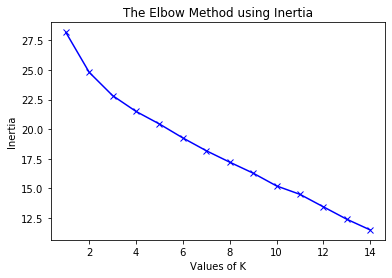

In [221]:
# plt.figure(figsize=(20,10))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [222]:
# set the number of clusters
kclusters = 5

# Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=50, max_iter=600, tol=0.0001, random_state=0)

kmeans.fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1])

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [223]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4.0,Park,Yoga Studio,Discount Store,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Coffee Shop,Portuguese Restaurant,Intersection,Pizza Place,Hockey Arena,French Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Yoga Studio
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1.0,Gym / Fitness Center,Breakfast Spot,Furniture / Home Store,Rental Car Location,Bakery,Food Truck,Design Studio,Coffee Shop,Spa,History Museum
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,1.0,Accessories Store,Coffee Shop,Boutique,Furniture / Home Store,Clothing Store,Carpet Store,Deli / Bodega,Cuban Restaurant,Creperie,Festival
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,3.0,Coffee Shop,Italian Restaurant,Bubble Tea Shop,Sandwich Place,Bike Rental / Bike Share,Portuguese Restaurant,Sushi Restaurant,Café,Park,Dumpling Restaurant


In [224]:
# dropping Neighbourhoods rows where no data is avaliable
toronto_merged=toronto_merged.dropna()

In [225]:
# converting Cluster_Labels to integer
toronto_merged['Cluster_Labels'] = toronto_merged.Cluster_Labels.astype(int)

In [226]:
# Optional: save toronto_merged df
toronto_merged.to_csv('toronto_merged.csv', index=False)

In [227]:
print(toronto_merged.shape)
toronto_merged

(85, 16)


,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4,Park,Yoga Studio,Discount Store,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Coffee Shop,Portuguese Restaurant,Intersection,Pizza Place,Hockey Arena,French Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Yoga Studio
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Gym / Fitness Center,Breakfast Spot,Furniture / Home Store,Rental Car Location,Bakery,Food Truck,Design Studio,Coffee Shop,Spa,History Museum
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,1,Accessories Store,Coffee Shop,Boutique,Furniture / Home Store,Clothing Store,Carpet Store,Deli / Bodega,Cuban Restaurant,Creperie,Festival
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,3,Coffee Shop,Italian Restaurant,Bubble Tea Shop,Sandwich Place,Bike Rental / Bike Share,Portuguese Restaurant,Sushi Restaurant,Café,Park,Dumpling Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,1,Pool,Yoga Studio,Discount Store,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Gay Bar,Burger Joint,Coffee Shop,Dessert Shop,Japanese Restaurant,Café,Breakfast Spot,Ethiopian Restaurant,Bubble Tea Shop,Salon / Barbershop
100,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,1,Park,Auto Workshop,Fast Food Restaurant,Farmers Market,Light Rail Station,Brewery,Dance Studio,Deli / Bodega,Fish & Chips Shop,Field
101,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509,1,Construction & Landscaping,Discount Store,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store


### Creating map of clusters

In [228]:
# create map
map_clusters = folium.Map(location=[To_latitude, To_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the Clusters 
* Examine each cluster and determine the discriminating venue categories that distinguish each cluster

#### Cluster 1

In [156]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,0,French Restaurant,Portuguese Restaurant,Hockey Arena,Coffee Shop,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,Harbourfront,0,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Restaurant,Breakfast Spot,Café,Chocolate Shop,Dessert Shop
3,"Lawrence Heights, Lawrence Manor",0,Clothing Store,Accessories Store,Coffee Shop,Shoe Store,Miscellaneous Shop,Carpet Store,Gift Shop,Furniture / Home Store,Boutique,Vietnamese Restaurant
4,Queen's Park,0,Coffee Shop,Park,Gym,Restaurant,Sushi Restaurant,Bar,Portuguese Restaurant,Mexican Restaurant,Diner,Café
5,Queen's Park,0,Coffee Shop,Park,Gym,Restaurant,Sushi Restaurant,Bar,Portuguese Restaurant,Mexican Restaurant,Diner,Café
...,...,...,...,...,...,...,...,...,...,...,...,...
97,"First Canadian Place, Underground city",0,Coffee Shop,Café,Gym,Steakhouse,Restaurant,Asian Restaurant,Bakery,Bar,Hotel,Seafood Restaurant
99,Church and Wellesley,0,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Yoga Studio,Men's Store,Bubble Tea Shop,Pub,Gym
100,Business Reply Mail Processing Centre 969 Eastern,0,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio,Restaurant
101,"Humber Bay, King's Mill Park, Kingsway Park So...",0,Construction & Landscaping,Baseball Field,Home Service,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


#### Cluster 2 

In [157]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"Silver Hills, York Mills",1,Cafeteria,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field


#### Cluster 3 

In [158]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,2,BBQ Joint,Park,Food & Drink Shop,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
16,Humewood-Cedarvale,2,Field,Trail,Park,Hockey Arena,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
21,Caledonia-Fairbanks,2,Park,Women's Store,Market,Fast Food Restaurant,Construction & Landscaping,Concert Hall,Comic Shop,Farmers Market,Falafel Restaurant,Event Space
40,"CFB Toronto, Downsview East",2,Airport,Park,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
49,"Downsview, North Park, Upwood Park",2,Bakery,Construction & Landscaping,Park,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
61,Lawrence Park,2,Park,Swim School,Lake,Bus Line,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
64,Weston,2,Park,Convenience Store,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
66,York Mills West,2,Park,Bank,Bar,Convenience Store,Yoga Studio,Electronics Store,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
68,"Forest Hill North, Forest Hill West",2,Trail,Park,Sushi Restaurant,Bus Line,Jewelry Store,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
77,"Kingsview Village, Martin Grove Gardens, Richv...",2,Pizza Place,Mobile Phone Shop,Park,Bus Line,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant


#### Cluster 4

In [159]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Downsview Central,3,Food Truck,Baseball Field,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Yoga Studio,Discount Store
57,"Emery, Humberlea",3,Baseball Field,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Discount Store


#### Cluster 5 

In [160]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Rouge, Malvern",4,Fast Food Restaurant,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
